# Fashion MNIST Hao's Solution

No GPU required! Run this on your potato.

The basic 7 steps for building models in general are listed so:
 1. Load Dataset
 2. Make Dataset Iterable
 3. Create Model Class
 4. Instantiate Model Class
 5. Instantiate Loss Class
 6. Instantiate Optimizer Class
 7. Train Model


### Run the below cells until 'stop' to get your data processed and loaded

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [2]:
'''
STEP 1: LOAD DATASET
'''
test_df = pd.read_csv('fashionmnist/fashion-mnist_test.csv')
test_df_labels = test_df['label']
test_pixels_df = test_df.drop('label', axis=1)

train_df = pd.read_csv('fashionmnist/fashion-mnist_train.csv')
train_pixels_df = train_df.drop('label', axis=1)
train_df_labels = train_df['label']

In [3]:
'''
STEP 1.5: defining and instantiating Dataset subclass 
'''

'''
This is our custom Dataset class. Remember from 1st meeting that we need this to pipeline our data into training our model.

The pipeline is important!!! At larger scale, machine learning can get bottlenecked at disk reads (in image classification for example)
so understanding the various stages is important. We don't have to worry about that kind of stuff now since we're just creating small
project models as opposed to complex production models.

NOTE: this is not the only way to create a dataset. An alternative is to simply pass in a dataframe that contains both pixel and label data.
Then we can index the label and pixel data inside of __getitem__ as opposed to separating labels and pixel data before hand like I did.
'''
class FashionDataset(Dataset):
    def __init__(self, dataframe, labels):
        self.labels = torch.LongTensor(labels)
        self.df = dataframe
        
    def __getitem__(self, index):
        # I'm using .loc to access the row of the dataframe by index
        a = self.df.loc[index]
#         a = (a - np.mean(a))/np.std(a)
        img = torch.Tensor(a)
        label = self.labels[index]
        return img, label

    def __len__(self):
        return len(self.labels)
    
'''
This class is for providing image data as (1, 28, 28) tensor as opposed to a (784) tensor. You
use these for conv2d layers which are powerful for image recognition!

NOTE: Please note that I normalized the data VERY INCORRECTLY. Here I am normalizing the data across 
each sample individually which is not good. I should be normalizing across the ENTIRE training data set.

Also, when I create the test dataset I should normalize it based on the TRAINING set's mean and standard deviation.
Since the model is trained on the training data, we want to make sure that we transform the test data the same way we
transform the training data. Otherwise it's like training a model to do one job and then testing it by on another job.
'''
class Fashion2DDataset(Dataset):
    def __init__(self, dataframe, labels):
        self.labels = torch.LongTensor(labels)
        self.df = dataframe
        
    def __getitem__(self, index):
        # I'm using .loc to access the row of the dataframe by index
        a = self.df.loc[index]
        a = (a - np.mean(a))/np.std(a)
        a = np.split(a, 28)
        a = np.array([a])
        img = torch.Tensor(a)
        
        label = self.labels[index]
        return img, label

    def __len__(self):
        return len(self.labels)

In [4]:
'''
STEP 2: MAKING DATASET ITERABLE
'''
train_dataset = Fashion2DDataset(train_pixels_df, train_df_labels.values)
test_dataset = Fashion2DDataset(test_pixels_df, test_df_labels.values)

batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [5]:
'''
STEP 3: CREATE MODEL CLASS
'''
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)  

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
class ConvolutionalNeuralNetModel(nn.Module):
    def __init__(self, output_dim):
        super(ConvolutionalNeuralNetModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.fc = nn.Linear(1024, output_dim)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [10]:
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28*28
hidden_dim = 100
output_dim = 10

# model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
model = ConvolutionalNeuralNetModel(output_dim)


In [11]:
'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()

In [12]:
'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
"""
Most of the time I use SGD. Feel free to use another optimizer if you wish.
What hyperparameters would you use/set here?
"""
learning_rate = .1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [14]:
'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
losses = []
accuracies = []
for epoch in range(1):
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
#         images = images.view(-1, 28*28).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 60 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Load images with gradient accumulation capabilities
#                 images = images.view(-1, 28*28).requires_grad_()

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            
            accuracies.append(accuracy)
            losses.append(loss.item())
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 60. Loss: 0.6154950857162476. Accuracy: 80
Iteration: 120. Loss: 0.7052783370018005. Accuracy: 77
Iteration: 180. Loss: 0.512718677520752. Accuracy: 81
Iteration: 240. Loss: 0.4165996313095093. Accuracy: 85
Iteration: 300. Loss: 0.3678703308105469. Accuracy: 84
Iteration: 360. Loss: 0.4152835011482239. Accuracy: 84
Iteration: 420. Loss: 0.4795871078968048. Accuracy: 85
Iteration: 480. Loss: 0.3599834740161896. Accuracy: 86
Iteration: 540. Loss: 0.27164870500564575. Accuracy: 86
Iteration: 600. Loss: 0.38277819752693176. Accuracy: 86


In [15]:
iterations = np.arange(60, 601, 60)
iterations
lossesnp = np.array(losses)*100

In [16]:
import matplotlib.pyplot as plt

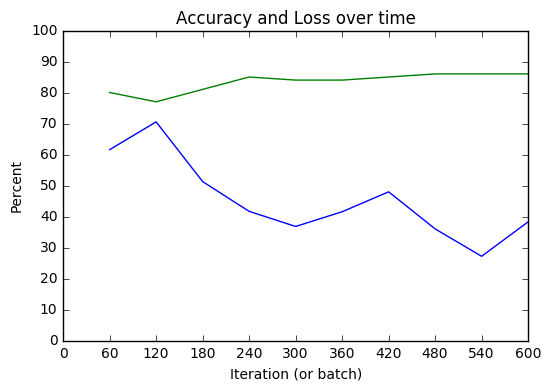

In [17]:
plt.plot(iterations, lossesnp)
plt.plot(iterations, accuracies)
plt.xticks(np.arange(0, 601, 60))
plt.yticks(np.arange(0,101,10))
plt.ylabel('Percent')
plt.xlabel('Iteration (or batch)')
plt.title('Accuracy and Loss over time')
plt.show()